In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math


## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('animation', html='jshtml')
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
## Read coordinates and indices

grid_coordinates = []
with open('../../../../Grids/AB_grid.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(',')
        point = (float(elements[0]),float(elements[1]))
        grid_coordinates.append(point)
        line = reader.readline()

jump_coordinates = []
with open('../../../../Grids/AB_jump_coordinates.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            temp = ele.replace('(', '').replace(')', '')
            if temp != 'stop':
                x = temp.split(',')[0]
                y = temp.split(',')[1]
                point = (float(x),float(y))
                data_block.append(point)
            else:
                break
        line = reader.readline()
        jump_coordinates.append(data_block)

jump_indices = []
with open('../../../../Grids/AB_jump_indices.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            if ele != 'stop':
                data_block.append(int(ele))
            else:
                break
        line = reader.readline()
        jump_indices.append(data_block)

bott_indices = []
with open('../AB_Bott_indices_flux_0.036.txt', 'r') as reader:
    line = reader.readline()
    
    while line != '':
        ele = line.replace('(', '').replace(')', '')
        elements = ele.split(',')
        package = (float(elements[0]), int(elements[1]))
        line = reader.readline()
        bott_indices.append(package)

# For drawing vertices use grid_coordinates
# For drawing lines use jump_coordinates
# For indices use jump_indices

## We now want to scale down the plot so it will fit inside a unit square in the 1st quadrant

# Compare x and y components seperatly to for the maximal distances along each axis
xs = [x for x,y in grid_coordinates]
ys = [y for x,y in grid_coordinates]

xs_length = abs(max(xs)) + abs(min(xs))
ys_length = abs(max(ys)) + abs(min(ys))

# We can now scale all xs and ys to fit inside a unit square
xs_scaled = [i/xs_length for i in xs]
ys_scaled = [i/ys_length for i in ys]
grid_scaled = [(x,y) for x, y in zip(xs_scaled, ys_scaled)]

# Same thing for all jump coodinates
jump_scaled = []
for i in jump_coordinates:
    xs_temp = [j[0]/xs_length for j in i]
    ys_temp = [j[1]/ys_length for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_scaled.append(jump_temp)


# The new vertices are stored in grid_scaled
# The new jumps are stored in jump_scaled

## IMPORTANT WE WILL USE THE GRID SCALED FOR ROTATIONS THIS MAKES THE WORK EASIER ##

# Time evolution by giving index of states
def time_evolve_evec(group_of_states, coefficients, time, evec, eval):

    hbar = 1
    t = time

    # Make the group of states in to vectors and multiply with time op
    phis = [c*np.exp(-1j*(eval[i]/hbar)*t)*evec[i] for i, c in zip(group_of_states, coefficients)]

    # Make a linear combination equally divided
    a = len(phis)
    psi = sum([x for x in phis])

    phi_norm = psi / (np.sqrt(np.vdot(psi,psi)))

    density_of_states = [(x.conj() * x).real for x in phi_norm]
    
    return phi_norm, density_of_states


In [3]:
# Hamiltonian cell
# The pure Hamiltonian
def Hamil_solve(z, w, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    
    # Start by finding the tile length
    tile_lens = [np.linalg.norm(np.array(z[0]) - np.array(x)) for x in w[0]]
    tile_lens_sum = np.sum(tile_lens)
    l  = tile_lens_sum/len(tile_lens)
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, w):
        products = [(i[0]*k[1] - k[0]*i[1]) for k in j]
        jump_products.append(products)
    phase_factors = []
    for i, j in zip(z, jump_products):
        phases = [-(phi/(2 * l**2)) * k for k in j]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = -J * np.exp(1j * t)

    # Now we find the eigenvalues and eigenvectors
    # Note that eigh returns normalized eigenvectors!
    # Note the eigenvectors are arranged in a matrix so eig_vecs[:,i] chooses the i'th column which is the i'th eigenvector
    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    return eig_vals, eig_vecs


# The unpure we just keep both positive and negative perturbations
# It is only a matter of scale
def Hamil_solve_perturb(z, w, B, perturb_vals):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H0 = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = np.arange(0, dim_H)
    # Calculate Peierls phase factor according to the 1st artcle 
    
    # Scaling via J, maybe energy factor
    J = 1

    # Start by finding the tile length
    tile_lens = [np.linalg.norm(np.array(z[0]) - np.array(x)) for x in w[0]]
    tile_lens_sum = np.sum(tile_lens)
    l  = tile_lens_sum/len(tile_lens)
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, w):
        products = [(i[0]*k[1] - k[0]*i[1]) for k in j]
        jump_products.append(products)
    terms_by_sites = []
    for i, j in zip(z, jump_products):
        phases = [-(phi/(2 * l**2)) * k for k in j]
        terms = [-J * np.exp(1j * t) for t in phases]
        terms_by_sites.append(terms)

    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, terms_by_sites):
        for k, t in zip(y, z):
            H0[x][k] = t

    # Add the diagonal perturbation

    perturbs = [abs(x) for x in perturb_vals]
    
    H_prime = np.diag(perturbs)
    #H_prime = np.diag(perturb_vals)

    # This is the new hamiltonian we will solve, just as previously
    H = H0 + H_prime

    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    
    return eig_vals, eig_vecs


In [4]:
# This part defines the R operator
def rotation(phi):
    operator = np.array([[np.cos(phi), -np.sin(phi)],[np.sin(phi), np.cos(phi)]])
    return operator

def translation(vector, coordinate):
    operator = vector + np.array([coordinate[0], coordinate[1]])
    return operator

def argz(z):
    a = np.angle(z)
    if a >= 0:
        return a
    else:
        return 2*np.pi + a

# This takes a vector from the basis of lattice sites and rotates it n-fold and assigns to a new vector in the same
def rot_op(site, n):
    # Site is a vector describing the coordinate of a supposed occupied site, which we want rotate (1/n)-fold
    # Rads tells the operator how much we should rotate
    rads = (2*np.pi)/(n)
    
    # Rotate site
    rot_site = np.matmul(rotation(rads), np.array(site))
    
    # We aim to assign the rotated site to an already exisiting coordiante pair, so we will compare with grid_scaled
    
    # Find sites close enough
    grain2 = -5
    close_by_ele = [(ele, count) for count, ele in enumerate(np.array(grid_scaled)) if -10**(grain2) <= np.linalg.norm(rot_site - np.array(ele)) <= 10**(grain2)]
    if len(close_by_ele) > 1 or len(close_by_ele) == 0:
        print(f'close_by_eles has a length of {len(close_by_ele)}')
        return
    else:
        # This more than likely only returns one element
        # This element comes with an index which we use to assign the rotated site to the preexisting coordinates
        new_site = grid_scaled[close_by_ele[0][1]]
        new_x = new_site[0]
        new_y = new_site[1]
        ns_index = close_by_ele[0][1]
        return (new_x, new_y), ns_index
    

# We now use the above function to construct an explicit rotation operator by applying and extracting the index for every basis element
dim = len(grid_scaled)
R = np.zeros((dim,dim),dtype= np.complex128)
indices = []
new_coordinates = []
for w in range(dim):
    coor, rot_index = rot_op(grid_scaled[w], 8)
    indices.append(rot_index)
    new_coordinates.append(coor)

complex_coor = [complex(*x) for x in grid_scaled]
complex_coor_rot = [complex(*x) for x in new_coordinates]
# With the new coordinates of each transformed coordinate we may determine the phase between 
#phases = [y/x for x, y in zip(complex_coor, complex_coor_rot)]
#theta = [arg(z) for z in phases]

for i, j in zip(range(dim), indices):
    # Note the order is to make sure in the picture of a matrix being made of column vectors, that we get the right non-zero entries
    # If we flip the order we get the transpose. Reason being that np intreprets entries along every row constituting the matrix in stead
    R[j][i] = 1

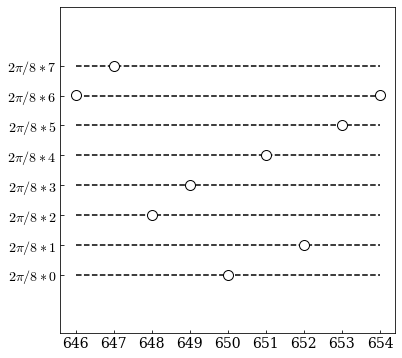

In [5]:
# The chosen flux has a hamiltonian has the greatest chance at not being degenerate
# We have chosen eigenvectors with different energies. Since R and H commute we expect common eigenvectors to exist 
# Extending the hope that H is not degenerate we now check if they are eigenvectors of R
elements_of_interval = np.loadtxt('../filter_evecs_flux_0036.txt')
elements_of_interval

# Calculate eigenvalues of the Hamiltonian
B_full = (2*np.pi)/(0.03825242185233838**2)
B_scale = 0.036
evals, evecs = Hamil_solve(grid_scaled, jump_scaled, (B_scale)*B_full)

# Rotate and 
indices = [int(x[1]) for x in elements_of_interval]
rotated_evecs = [np.matmul(R,evecs[int(x)]) for x in indices]
unrotated_evecs = [evecs[x] for x in indices]

phases = [[y_ent/x_ent for x_ent, y_ent in zip(x,y)] for x,y in zip(unrotated_evecs, rotated_evecs)]
phases_avg = [sum(x)/(len(x)) for x in phases]

phases_theta = args = [argz(x) for x in phases_avg]

fig, ax = plt.subplots(figsize= (6,6))

# Xs and Ys
xs = indices
ys = [math.fmod(x, 2*np.pi) for x in phases_theta]
ks = np.arange(0,8,1)
# Plot
for k in ks:
    ax.hlines(y= 2*np.pi/8*k, xmin= min(xs), xmax= max(xs), linestyles= '--', color= 'k', zorder= 1)

ax.scatter(xs, ys, facecolor= 'w', edgecolor= 'k', s= 100, zorder= 2)

# Plotting things
xlabels = [f'{x}' for x in indices]
xlabel_placements = [x for x in indices]
ylabels = [r'$2\pi/8* {}$'.format(k) for k in ks]
ylabel_placements = [(2*np.pi/8)*k for k in ks]

ax.axis('equal')

ax.set_xticks(xlabel_placements)
ax.set_xticklabels(xlabels)
ax.set_yticks(ylabel_placements)
ax.set_yticklabels(ylabels)

plt.show()

In [6]:
# Both groups here have a difference of ks +/- 1
group1 = [650, 652]
group2 = [650, 647]
# Both linear combinations yield one coherent transport

# Attempts at poorer overlaps but with greater difference in ks
group3 = [648, 651]
group4 = [648, 653]
group5 = [648, 654]
group6 = [648, 652]
group7 = [648, 650]
group8 = [649, 647]
group9 = [649, 650]
group10 = [649, 652]
group11 = [653, 654]

groups_of_interest = [group11]

In [7]:
# In this cell we calculate the unperturbed Hamiltonian, so that we may gauge the energy difference
# The energy difference is used for generating the perturbations
# Set the value of the magnetic field
B_full = (2*np.pi)/(0.03825242185233838**2)
B_scale = 0.036

evals, evecs = Hamil_solve(grid_scaled, jump_scaled, (B_scale)*B_full)

# We already know we want to look at the "double step" of the flux cutout
# Calculate every delta_E between every consecutive state
delta_Es = [evals[i+1] - evals[i] for i in indices if i != indices[-1]]
# Calculate an average delta_E so that we have an estimate of perturbation size 
avg_delta_Es = (1/(len(delta_Es))) * sum(delta_Es)
# Note that the calculation only needs to happen once before being put into generator script
print(avg_delta_Es)

0.03240036249253203


In [8]:
"""# Load in Vs from other script and call them perturbs
perturbs = np.loadtxt('Perturb_gen/Perturbs_flux_0036.txt')
# Define the scaling of Vs
V_scales = np.arange(0,10.1, 0.1)

all_vals = [Hamil_solve_perturb(grid_scaled, jump_scaled, (B_scale)*B_full, x*perturbs) for x in V_scales]

all_evals = [x for x,y in all_vals]
all_evecs = [y for x,y in all_vals]

pure_evals = all_evals[0]
pure_evecs = all_evecs[0]

unpure_evals = all_evals[1:]
unpure_evecs = all_evecs[1:]
"""

"# Load in Vs from other script and call them perturbs\nperturbs = np.loadtxt('Perturb_gen/Perturbs_flux_0036.txt')\n# Define the scaling of Vs\nV_scales = np.arange(0,10.1, 0.1)\n\nall_vals = [Hamil_solve_perturb(grid_scaled, jump_scaled, (B_scale)*B_full, x*perturbs) for x in V_scales]\n\nall_evals = [x for x,y in all_vals]\nall_evecs = [y for x,y in all_vals]\n\npure_evals = all_evals[0]\npure_evecs = all_evecs[0]\n\nunpure_evals = all_evals[1:]\nunpure_evecs = all_evecs[1:]\n"

In [9]:
## Magic line for animation
%matplotlib inline
# Attempt at animating time evolution


for group in groups_of_interest:
    # Set figure up first
    fig, ax = plt.subplots(figsize=(6,6))
    # Set bascis
    sites = ax.scatter(x=[], y=[], c=[])

    xs = [w[0] for w in grid_scaled]
    ys = [w[1] for w in grid_scaled]


    # Set timesteps, state of choice for animation, and number of frames
    timestep = 3
    n_frames = 150
    coefs = [1,1]

    psi_0, dos_0 = time_evolve_evec(group, coefs, 0, evecs, evals)

    dos_max = max(dos_0)

    plt.set_cmap('hot_r')

    # This function will do the animating
    def update(i):
        plt.clf()
        # t is the steps we progress, timestep sets the steplength
        t = i * timestep

        # Using the time evolution to find density of states for each increment
        psi, dos = time_evolve_evec(group, coefs, t, evecs, evals)
        cf = plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= dos_max)
        plt.title(f'Timestep= {timestep} and Frames= {n_frames}')
        #plt.legend(loc= 3)
        plt.colorbar(cf)
        plt.axis('equal')


    anim = FuncAnimation(fig, update, frames= n_frames, interval=250)

    empty = '_'
    name_file = empty.join([str(x) for x in group])

    anim.save(f'es_time_evolve/Ang_exam/Group_{name_file}.gif', writer='imagemagick', fps=24)

    plt.close()

    #anim

In [10]:
times = [np.arange(0,21,7), np.arange(0,12,4)]
for group, time in zip(groups_of_interest, times):

    fig, ax = plt.subplots(1, len(time) + 1, figsize=(10, 3), gridspec_kw={"width_ratios":[0.33, 0.33, 0.33, 0.03]})
    
    for z, t in enumerate(time):
        # Plot all possible paths between vertices
        for i,j in zip(grid_scaled, jump_scaled):
            xs = [w[0] for w in j]
            ys = [w[1] for w in j]
            for l,k in zip(xs,ys):
                ax[z].plot([i[0], l], [i[1], k], color= 'k', zorder= 1, linewidth= 0.5)

        # Get points for scatter plot
        xs = [w[0] for w in grid_scaled]
        ys = [w[1] for w in grid_scaled]

        # Time evolution segment
        coefs = [1,1]
        # Initial setup
        psi_0, dos_0 = time_evolve_evec(group, coefs, 0, evecs, evals)
        dos_max = max(dos_0)

        # Actual evolution
        tim = t
        psi, dos = time_evolve_evec(group, coefs, tim, evecs, evals)

        # Plotting part
        cax = ax[z].scatter(x= xs, y= ys, c= dos, vmin=0, vmax= dos_max)
        ax[z].set_xticks([])
        ax[z].set_yticks([])
        ax[z].axis('equal')

    end_ax = len(time) -1
    cb = fig.colorbar(cax, cax=ax[len(time)], orientation='vertical')

    empty = '_'
    name_file = empty.join([str(x) for x in group])

    plt.set_cmap('hot_r')
    plt.savefig(f'es_time_evolve/Ang_exam/TE_frames/{name_file}.png', bbox_inches= 'tight')
    plt.close()
